# Space-time K-function analysis for division counts

This time using the webpage cited in the Levayer paper which I ended up finding on web archive.

https://web.archive.org/web/20210513032304/https://www.seas.upenn.edu/~ese502/

Particularly this chapter:
https://web.archive.org/web/20210507072822/https://www.seas.upenn.edu/~ese502/NOTEBOOK/Part_I/6_Space_Time_Processes.pdf

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from dataio import load_radial_df
from render import render_from_df
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Space-Time Point Processes

Event sequences exhibit space-time clustering if events that are close in space tend to be closer in time than would be expected by chance alone. Consider a space-time pattern of events

<img src="https://latex.codecogs.com/svg.image?\left\{e_{i}=(s_{i},t_{i}:i=1,...,n)&space;\right\}" title="eq" />

in region R where s<sub>i</sub> denotes location of an event e<sub>i</sub> in R and t<sub>i</sub> denotes the time at which it occurs. If we are interested in the numbers of events that are close to e<sub>i</sub> then for each spatial distance h and time increment Δ it is natural to define the corresponding space-time neighbourhood of e<sub>i</sub> by the Cartesian product 

<img src="https://latex.codecogs.com/svg.image?C_{(h,&space;\Delta)}(e_{i})=\left\{&space;(s,t):\left\|s_{i}&space;-s\right\|\leq&space;h,\left|t_{i}-t&space;\right|\leq&space;\Delta\right\}" title="eq" />

<img src="https://latex.codecogs.com/svg.image?=&space;\left\{s:\left\|s_{i}&space;-s\right\|\leq&space;h\right\}&space;\times&space;\left\{t:\left\|t_{i}&space;-s\right\|\leq&space;\Delta\right\}" title="eq" />

Which corresponds to cylindrical neighbourhoods in space-time. As in two dimensions, one can define a relevant space-time region as the Cartesian product of RxT, with the default time interval usually taken to be the smallest time interval containing all event times. 

Thus, the extension of the K-functions is completely straightforward and the space-time indicator functions are the same, but with an added temporal dimension condition.

<img src="https://latex.codecogs.com/svg.image?I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)=&space;\begin{cases}1,&space;&&space;\left(d_{i&space;j}&space;\leq&space;h\right)&space;\text&space;{&space;and&space;}\left(t_{i&space;j}&space;\leq&space;\Delta\right)&space;\\&space;0,&space;&&space;\text&space;{&space;otherwise&space;}\end{cases}">

Which results in the space-time K-function of the expected number of addition events within space-time distance (h, Δ) of a randomly selected event as


<img src="https://latex.codecogs.com/svg.image?K(h,&space;\Delta)=\frac{1}{\lambda_{s&space;t}}&space;\sum_{j&space;\neq&space;i}&space;E\left[I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)\right]">

For any given pattern of size n, the pooled form of this function is 

<img src="https://latex.codecogs.com/svg.image?K(h,&space;\Delta)=\frac{1}{n&space;\cdot&space;\lambda_{s&space;t}}&space;\sum_{i=1}^{n}&space;\sum_{j&space;\neq&space;i}&space;E\left[I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)\right]">

and this implies that the natural estimator of K(h, Δ) is given by the sample space-time K-function:

<img src="https://latex.codecogs.com/svg.image?\hat{K}(h,&space;\Delta)=\frac{1}{n&space;\cdot&space;\lambda_{s&space;t}}&space;\sum_{i=1}^{n}&space;\sum_{j&space;\neq&space;i}&space;I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)">

Where the sample estimate, lambda_st, of the space-time intensity is given by 

<img src="https://latex.codecogs.com/svg.image?\hat{\lambda}_{\mathrm{st}}=\frac{n}{a(R)&space;\cdot\left(t_{\max&space;}-t_{\min&space;}\right)}">

In [2]:
def K_st_func(h_, delta_, n, lambda_st, df):
    K_st = np.zeros((len(h_), len(delta_)))
    ### trim the dataframe to git rid of dij, tij > max/min h_, delta_, reducing the number of iterations needed
    df.drop(df.index[df['dij'] > h_.max()], inplace=True)
    df.drop(df.index[df['tij'] > delta_.max()], inplace=True)
    df.drop(df.index[df['tij'] < delta_.min()], inplace=True)
    for i, h in tqdm(enumerate(h_), total = len(delta_), desc = 'Iterating over space-time'):
        for j, delta in enumerate(delta_):
                ### if delta is negative, then needs to be greater than or less than zero
                if delta < 0:
                    K_st[i, j] = (1/(n * lambda_st)) * len(df[((df['tij']) <= 0) & ((df['tij']) >= (delta)) & (df['dij'] <= h)])
                ### if delta is positive, then has to be greater than zero less than delta
                else: 
                    K_st[i, j] = (1/(n * lambda_st)) * len(df[((df['tij']) >= 0) & ((df['tij']) <= (delta)) & (df['dij'] <= h)])

    return K_st

def K_st_tau_func(h_, delta_, n, lambda_st, df, tau): ### for temporal indistinguishability tests
    K_st_tau = np.zeros((len(h_), len(delta_)))
    ### already done by the original k func 
    ### trim the dataframe to git rid of dij, tij > max/min h_, delta_, reducing the number of iterations needed
#     df.drop(df.index[df['dij'] > h_.max()], inplace=True)
#     df.drop(df.index[df['tij'] > delta_.max()], inplace=True)
#     df.drop(df.index[df['tij'] < delta_.min()], inplace=True)
    for i, h in enumerate(h_):
        for j, delta in (enumerate(delta_)):#, total = len(delta_), desc = 'Iterating over space-time'):
            ### if delta is negative, then needs to be greater than or less than zero
            if delta < 0:
                K_st_tau[i, j] = (1/(n * lambda_st)) * len(df[((df[f'tpi τ = {tau}']) <= 0) & ((df[f'tpi τ = {tau}']) >= (delta)) & (df['dij'] <= h)])
            ### if delta is positive, then has to be greater than zero less than delta
            else: 
                K_st_tau[i, j] = (1/(n * lambda_st)) * len(df[((df[f'tpi τ = {tau}']) >= 0) & ((df[f'tpi τ = {tau}']) <= (delta)) & (df['dij'] <= h)])

    return K_st_tau

#### Implementing this analysis on a dataset of wild-type division localisations around N = 1 Scribble<sup>KD</sup> apoptosis



In [7]:
file_list = glob.glob('/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/*')
file_list = [file for file in file_list if 'GV0796_Pos3_Scr_-9_' in file and 'events' in file]
len(file_list)

1

In [8]:
### loading all division localisations regardless of whether or not the scan leaves the FOV etc. (still cropping edge effects and loading all info)
df = load_radial_df(file_list, crop_amount = 20, streamline = False)# R = 100, crop_amount = True, streamline = False, strict_filtering = True)

  0%|          | 0/1 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1


/home/nathan/analysis/cell-comp-analysis/radial_analysis/dataio.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
/home/nathan/analysis/cell-comp-analysis/radial_analysis/dataio.py:91: FutureWarning: The default value of regex will change from True to False in a future version.
  df['y'] = df['y'].str.replace('[()]', '')


In [9]:
### renaming columns to fit with nomenclature of K-function
df = df.rename(columns={'Distance from apoptosis': 'dij', 'Time since apoptosis': 'tij'})

The following dataframe shows the distance (dij) and time (tij) of division events from a central focal apoptotic event. 

In [10]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID
0,100,322.666667,238,683,1126,-14.000000,GV0796_Pos3_Scr_-9
1,92,287.000000,10,732,841,-29.200000,GV0796_Pos3_Scr_-9
2,94,353.666667,135,68,1373,-20.866667,GV0796_Pos3_Scr_-9
3,95,288.000000,17,97,1218,-28.733333,GV0796_Pos3_Scr_-9
4,97,60.333333,223,78,162,-15.000000,GV0796_Pos3_Scr_-9
...,...,...,...,...,...,...,...
742,3621,262.000000,892,151,1149,29.600000,GV0796_Pos3_Scr_-9
743,4583,125.666667,879,46,707,28.733333,GV0796_Pos3_Scr_-9
744,4657,243.666667,963,899,132,34.333333,GV0796_Pos3_Scr_-9
745,4736,60.666667,976,183,184,35.200000,GV0796_Pos3_Scr_-9


In [11]:
n1 = len(set(df['Cell ID']))
print('Total number of division events, n = ', n1)
n2 = len(set(df['Focal ID'])) #len(file_list)
print('Total number of focal apoptotic events, n = ', n2)

Total number of division events, n =  747
Total number of focal apoptotic events, n =  1


In [12]:
T = max(df['tij']) - min(df['tij'])
print('Default time interval, T = ', T)

Default time interval, T =  66.33333333333333


In [13]:
x_range = max(df['x']) - min(df['x'])
y_range = max(df['y']) - min(df['y'])
### convert from pixels to micrometres (/3)
a = (x_range/3)*(y_range/3)
print('Total area (FOV) in micrometres, a(R) =', round(a), 'microns squared')

Total area (FOV) in micrometres, a(R) = 200893 microns squared


In [14]:
n = n1
lambda_st = n/(a*T)
print('Space-time intensity parameter, lambda_st = ', lambda_st)
lambda_1 = n1/(a*T)
print('Space-time intensity parameter for division events, lambda_1 = ', lambda_1)
lambda_2 = n2/(a*T)
print('Space-time intensity parameter for apoptotic events, lambda_2 = ', lambda_2)

Space-time intensity parameter, lambda_st =  5.605614853320163e-05
Space-time intensity parameter for division events, lambda_1 =  5.605614853320163e-05
Space-time intensity parameter for apoptotic events, lambda_2 =  7.50416981702833e-08


In [15]:
delta_ = np.linspace(-5,5, 100)
h_ = np.linspace(0,100, 100)

In [16]:
file_list

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0796_Pos3_Scr_-9_N_events_wt_rad_1600_t_range_1600_focal_txy_448_205_365.csv']

In [17]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID
0,100,322.666667,238,683,1126,-14.000000,GV0796_Pos3_Scr_-9
1,92,287.000000,10,732,841,-29.200000,GV0796_Pos3_Scr_-9
2,94,353.666667,135,68,1373,-20.866667,GV0796_Pos3_Scr_-9
3,95,288.000000,17,97,1218,-28.733333,GV0796_Pos3_Scr_-9
4,97,60.333333,223,78,162,-15.000000,GV0796_Pos3_Scr_-9
...,...,...,...,...,...,...,...
742,3621,262.000000,892,151,1149,29.600000,GV0796_Pos3_Scr_-9
743,4583,125.666667,879,46,707,28.733333,GV0796_Pos3_Scr_-9
744,4657,243.666667,963,899,132,34.333333,GV0796_Pos3_Scr_-9
745,4736,60.666667,976,183,184,35.200000,GV0796_Pos3_Scr_-9


In [18]:
K_st = K_st_func(h_, delta_, n, lambda_st, df)

Iterating over space-time:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Space-time K-function \n for N = 1 focal apoptosis')

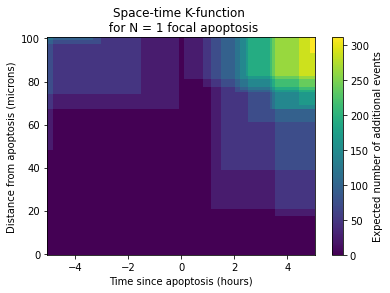

In [15]:
pc = plt.pcolormesh(delta_, h_, K_st, )
plt.colorbar(label = 'Expected number of additional events',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance from apoptosis (microns)')
plt.title('Space-time K-function \n for N = 1 focal apoptosis')

## Temporal indistinguishability hypothesis

Random permutations of different time points to see if the K-function patterns still hold.

In [16]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID
31,134,69.333333,514,412,341,4.400000,GV0796_Pos3_Scr_-9
52,126,47.666667,375,284,271,-4.866667,GV0796_Pos3_Scr_-9
138,272,97.000000,402,203,639,-3.066667,GV0796_Pos3_Scr_-9
170,441,81.333333,450,439,436,0.133333,GV0796_Pos3_Scr_-9
171,440,77.000000,460,413,468,0.800000,GV0796_Pos3_Scr_-9
195,527,74.333333,426,200,133,-1.466667,GV0796_Pos3_Scr_-9
199,534,67.333333,447,340,515,-0.066667,GV0796_Pos3_Scr_-9
200,535,99.666667,398,337,591,-3.333333,GV0796_Pos3_Scr_-9
305,849,20.333333,464,244,412,1.066667,GV0796_Pos3_Scr_-9
306,848,67.000000,499,295,545,3.400000,GV0796_Pos3_Scr_-9


The cell below mixes the order of the time points of the events for N different permutations, naming the new shuffled time points t<sub>pi</sub> and the indices of the permutations as tau.

In [17]:
### define the number of permutations to make
N = 1000
for tau in tqdm(range(N)):
    df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-b49379d3ea8c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)


In [18]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID,tpi τ = 0,tpi τ = 1,tpi τ = 2,...,tpi τ = 990,tpi τ = 991,tpi τ = 992,tpi τ = 993,tpi τ = 994,tpi τ = 995,tpi τ = 996,tpi τ = 997,tpi τ = 998,tpi τ = 999
31,134,69.333333,514,412,341,4.400000,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,126,47.666667,375,284,271,-4.866667,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,272,97.000000,402,203,639,-3.066667,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,441,81.333333,450,439,436,0.133333,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,440,77.000000,460,413,468,0.800000,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,527,74.333333,426,200,133,-1.466667,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,534,67.333333,447,340,515,-0.066667,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,535,99.666667,398,337,591,-3.333333,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,849,20.333333,464,244,412,1.066667,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,848,67.000000,499,295,545,3.400000,GV0796_Pos3_Scr_-9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now calculating the space-time K-function for each permutation of time points

In [19]:
K_st_tau = {}
for tau in tqdm(range(N), desc = 'Progress through tau'):
#     if tau in K_st_tau.keys():
#         continue
    K_st_tau[tau] = K_st_tau_func(h_, delta_, n, lambda_st, df, tau)

Progress through tau:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
len(df[((df[f'tpi τ = {tau}']) <= 0) & ((df[f'tpi τ = {tau}']) >= (delta)) & (df['dij'] <= h)])

Checking to see if any two of the randomly time-indices-switched K-function arrays are identical (they should not be)

In [ ]:
def arrays_equal(a, b):
    if a.shape != b.shape:
        return False
    for ai, bi in zip(a.flat, b.flat):
        if ai != bi:
            return False
    return True

In [ ]:
import itertools
for a, b in tqdm(itertools.combinations(K_st_tau, 2), total = 499500):
    array1 = K_st_tau[a]
    array2 = K_st_tau[b]
    if arrays_equal(array1, array2) == True:
        print(a, b, 'are equal')

Saving out space-time K-function permutations

In [ ]:
import pickle
with open('K_st_tau_1000_N=1.pkl', 'wb') as f:
    pickle.dump(K_st_tau, f)

## Random labelling test

For the observed sample space-time K-function (K_st), under temporal indistinguishability hypothesis each observed value should be a typical sample from the list of values of the simulated random relabelings (K_st_tau). 
If we let M<sup>0</sup><sub>+</sub> denote the number of simulated random relabellings where
![original image](https://cdn.mathpix.com/snip/images/Wvkoq-491AhCE2m_G6zGw_L_3ED-5hRLSt7cNqDAC5M.original.fullsize.png)

then the probability of obtaining a value as large as the observed K-function value under this hypothesis is estimated by the space-time clustering p-value

![original image](https://cdn.mathpix.com/snip/images/526PhmFLMC_EuYZD2w1DfvWRy6jzb4JdlYYX_LGj0II.original.fullsize.png)

Similarly, if we let M0_minus denote the number of simulated random relabelling with 

![original image](https://cdn.mathpix.com/snip/images/ggXq7evPggixcgZ_Fi-46YcEWPo77kqt_-dkqGqwgqw.original.fullsize.png)

then the estimated probaility of obtaining a value as small as the original observed K-function under this hypothesis is given by the space-time dispersion p-value

![original image](https://cdn.mathpix.com/snip/images/FC8MktUTmWsfNpj8lo4j4eewvhiOyZhsaxH5egDg6ME.original.fullsize.png)

In [ ]:
N = 1000#len(K_st_tau)
P_st_clust = np.zeros(K_st.shape)
P_st_disp = np.zeros(K_st.shape)

for i, h in enumerate(tqdm(h_, total = len(h_))):
    for j, delta in enumerate(delta_):
        M0_plus = len([tau for tau in K_st_tau if K_st_tau[tau][i,j] >= K_st[i,j]])
        P_st_clust[i,j] = (M0_plus + 1)/(N+1)
        M0_minus = len([tau for tau in K_st_tau if K_st_tau[tau][i,j] <= K_st[i,j]])
        P_st_disp[i,j] = (M0_minus + 1)/(N+1)
    

In [ ]:
pc = plt.pcolormesh(delta_, h_, P_st_clust, cmap = 'Reds', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title('Space-time clustering p-value contour map \n for N = 1 focal apoptosis')

In [ ]:
pc = plt.pcolormesh(delta_, h_, P_st_disp, cmap = 'Blues_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title('Space-time dispersion p-value contour map \n for N = 1 focal apoptosis')

Cropped dispersion p-value plot showing a more accurate range of values for the furthest distances ie. d = 80-100 microns, across all time.

In [ ]:
plt.imshow(P_st_disp[80:100,:])
plt.colorbar()

These plots seem to suggest no strong clustering but there is evidence for dispersion beyond the immediate local neighbourhood across all time. The dispersion plot indicates that there might be significantly less instances of division events occuring in neighbourhoods further away than would be detected under the temporal indistinguishability hypothesis. Not going to dwell too long on the conclusion of this analysis as it is only N=1, instead I need to scale up to all central focal events.

# Repeating analysis but over cumulative K-function measure...

Will surely need to generate new K-function tau values, ie. randomly swap the time indices of all new events found in cumulative measure. This could take ages. 

But how do I cumulatively measure a K-function? Assume all central focal events are the same single event? But then I have repeat measures of division events occurring... But the relevant distances to each focal event for each division event will be different, so not strictly a repeat measurement.

In [21]:
file_list = glob.glob('/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/*')
file_list = [file for file in file_list if 'events' in file]
len(file_list)

1839

In [22]:
### loading all division localisations regardless of whether or not the scan leaves the FOV etc. (still cropping edge effects and loading all info)
df = load_radial_df(file_list, crop_amount = 20, streamline = False)# R = 100, crop_amount = True, streamline = False, strict_filtering = True)

  0%|          | 0/1839 [00:00<?, ?it/s]

/home/nathan/analysis/cell-comp-analysis/radial_analysis/dataio.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
/home/nathan/analysis/cell-comp-analysis/radial_analysis/dataio.py:91: FutureWarning: The default value of regex will change from True to False in a future version.
  df['y'] = df['y'].str.replace('[()]', '')


Number of focal cells included in cumulative scan: 1839


In [23]:
### renaming columns to fit with nomenclature of K-function
df = df.rename(columns={'Distance from apoptosis': 'dij', 'Time since apoptosis': 'tij'})

In [32]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID
2,966,30.333333,1059,552,816,4.266667,GV0819_Pos3_Scr_-1735
9,1238,77.333333,960,684,708,-2.333333,GV0819_Pos3_Scr_-1735
16,1360,66.000000,974,461,1082,-1.400000,GV0819_Pos3_Scr_-1735
17,1361,70.333333,1060,506,1114,4.333333,GV0819_Pos3_Scr_-1735
53,1659,78.333333,969,429,683,-1.733333,GV0819_Pos3_Scr_-1735
...,...,...,...,...,...,...,...
397990,253,27.333333,633,405,517,4.000000,GV0796_Pos6_Scr_-60
398466,1270,99.666667,1169,54,776,1.600000,GV0819_Pos2_Scr_-490
398478,1355,65.333333,1109,452,854,-2.400000,GV0819_Pos2_Scr_-490
398496,1489,74.333333,1119,75,907,-1.733333,GV0819_Pos2_Scr_-490


In [25]:
n1 = len(df['Cell ID'])#len(set(df['Cell ID']))
print('Total number of division events, n = ', n1)
n2 = len(set(df['Focal ID'])) #len(file_list)
print('Total number of focal apoptotic events, n = ', n2)

Total number of division events, n =  398511
Total number of focal apoptotic events, n =  1838


In [26]:
T = max(df['tij']) - min(df['tij'])
print('Default time interval, T = ', T)

Default time interval, T =  106.6


In [27]:
x_range = max(df['x']) - min(df['x'])
y_range = max(df['y']) - min(df['y'])
### convert from pixels to micrometres (/3)
a = (x_range/3)*(y_range/3)
print('Total area (FOV) in micrometres, a(R) =', round(a), 'microns squared')

Total area (FOV) in micrometres, a(R) = 201067 microns squared


In [28]:
n = n1
lambda_st = n/(a*T)
print('Space-time intensity parameter, lambda_st = ', lambda_st)
lambda_1 = n1/(a*T)
print('Space-time intensity parameter for division events, lambda_1 = ', lambda_1)
lambda_2 = n2/(a*T)
print('Space-time intensity parameter for apoptotic events, lambda_2 = ', lambda_2)

Space-time intensity parameter, lambda_st =  0.01859272435690078
Space-time intensity parameter for division events, lambda_1 =  0.01859272435690078
Space-time intensity parameter for apoptotic events, lambda_2 =  8.575278315525453e-05


In [29]:
delta_ = np.linspace(-5,5, 100)
h_ = np.linspace(0,100, 100)

In [30]:
n

398511

In [31]:
K_st = K_st_func(h_, delta_, n, lambda_st, df)

Iterating over space-time:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
K_st = K_st_func(h_, delta_, n, lambda_st, df)

Iterating over space-time:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Space-time K-function \n for N = 1838 focal apoptosis')

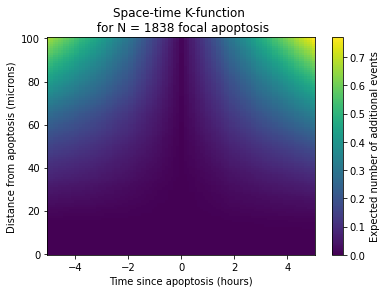

In [16]:
pc = plt.pcolormesh(delta_, h_, K_st, )
plt.colorbar(label = 'Expected number of additional events',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance from apoptosis (microns)')
plt.title(f'Space-time K-function \n for N = {n2} focal apoptosis')

Why is this plot symmetrical? Is it symmetrical? It only appears symmetrical around the zero values

Text(0.5, 1.0, 'Checking temporal symmetry of space-time K-function plot')

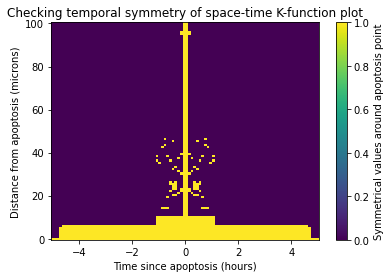

In [34]:
pc = plt.pcolormesh(delta_, h_, (np.fliplr(K_st) == K_st), )
plt.colorbar(label = 'Symmetrical values around apoptosis point',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance from apoptosis (microns)')
plt.title(f'Checking temporal symmetry of space-time K-function plot')

The plot is only symmetrical around the zero values and looks this was as it is a cumulative measure of expected values around the origin of t = 0.

### Cumulative temporal indistinguishability test

Random permutations of different time points to see if the K-function patterns still hold.

In [35]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID
2,966,30.333333,1059,552,816,4.266667,GV0819_Pos3_Scr_-1735
9,1238,77.333333,960,684,708,-2.333333,GV0819_Pos3_Scr_-1735
16,1360,66.000000,974,461,1082,-1.400000,GV0819_Pos3_Scr_-1735
17,1361,70.333333,1060,506,1114,4.333333,GV0819_Pos3_Scr_-1735
53,1659,78.333333,969,429,683,-1.733333,GV0819_Pos3_Scr_-1735
...,...,...,...,...,...,...,...
397990,253,27.333333,633,405,517,4.000000,GV0796_Pos6_Scr_-60
398466,1270,99.666667,1169,54,776,1.600000,GV0819_Pos2_Scr_-490
398478,1355,65.333333,1109,452,854,-2.400000,GV0819_Pos2_Scr_-490
398496,1489,74.333333,1119,75,907,-1.733333,GV0819_Pos2_Scr_-490


In [70]:
df = df.reset_index()

In [71]:
df

,index,Cell ID,dij,Frame,x,y,tij,Focal ID,tpi τ = 0,tpi τ = 1,...,tpi τ = 990,tpi τ = 991,tpi τ = 992,tpi τ = 993,tpi τ = 994,tpi τ = 995,tpi τ = 996,tpi τ = 997,tpi τ = 998,tpi τ = 999
0,2,966,30.333333,1059,552,816,4.266667,GV0819_Pos3_Scr_-1735,4.266667,4.266667,...,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667
1,9,1238,77.333333,960,684,708,-2.333333,GV0819_Pos3_Scr_-1735,-2.333333,-2.333333,...,-2.333333,-2.333333,-2.333333,-2.333333,-2.333333,-2.333333,-2.333333,-2.333333,-2.333333,-2.333333
2,16,1360,66.000000,974,461,1082,-1.400000,GV0819_Pos3_Scr_-1735,-1.400000,-1.400000,...,-1.400000,-1.400000,-1.400000,-1.400000,-1.400000,-1.400000,-1.400000,-1.400000,-1.400000,-1.400000
3,17,1361,70.333333,1060,506,1114,4.333333,GV0819_Pos3_Scr_-1735,4.333333,4.333333,...,4.333333,4.333333,4.333333,4.333333,4.333333,4.333333,4.333333,4.333333,4.333333,4.333333
4,53,1659,78.333333,969,429,683,-1.733333,GV0819_Pos3_Scr_-1735,-1.733333,-1.733333,...,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10583,397990,253,27.333333,633,405,517,4.000000,GV0796_Pos6_Scr_-60,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
10584,398466,1270,99.666667,1169,54,776,1.600000,GV0819_Pos2_Scr_-490,1.600000,1.600000,...,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000
10585,398478,1355,65.333333,1109,452,854,-2.400000,GV0819_Pos2_Scr_-490,-2.400000,-2.400000,...,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000
10586,398496,1489,74.333333,1119,75,907,-1.733333,GV0819_Pos2_Scr_-490,-1.733333,-1.733333,...,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333,-1.733333


In [80]:
### define the number of permutations to make
N = 1000
for tau in tqdm(range(N)):
    df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-80-b49379d3ea8c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)


In [81]:
df

,index,Cell ID,dij,Frame,x,y,tij,Focal ID,tpi τ = 0,tpi τ = 1,...,tpi τ = 990,tpi τ = 991,tpi τ = 992,tpi τ = 993,tpi τ = 994,tpi τ = 995,tpi τ = 996,tpi τ = 997,tpi τ = 998,tpi τ = 999
0,2,966,30.333333,1059,552,816,4.266667,GV0819_Pos3_Scr_-1735,2.866667,-3.000000,...,2.933333,-1.800000,1.533333,-1.000000,-4.600000,2.800000,2.133333,-1.066667,4.133333,-1.333333
1,9,1238,77.333333,960,684,708,-2.333333,GV0819_Pos3_Scr_-1735,2.600000,-2.400000,...,4.266667,-0.066667,4.333333,-3.000000,0.333333,-4.400000,-0.933333,-3.000000,1.933333,-1.800000
2,16,1360,66.000000,974,461,1082,-1.400000,GV0819_Pos3_Scr_-1735,-4.200000,1.933333,...,-1.866667,0.866667,2.600000,3.733333,1.733333,-4.400000,-1.866667,3.733333,0.333333,-4.733333
3,17,1361,70.333333,1060,506,1114,4.333333,GV0819_Pos3_Scr_-1735,-2.400000,-3.266667,...,2.533333,-4.666667,-1.800000,-1.533333,0.866667,0.733333,-2.600000,2.333333,1.933333,-4.333333
4,53,1659,78.333333,969,429,683,-1.733333,GV0819_Pos3_Scr_-1735,0.133333,4.266667,...,2.600000,0.000000,3.800000,1.266667,1.666667,-3.200000,0.800000,-2.733333,0.600000,0.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10583,397990,253,27.333333,633,405,517,4.000000,GV0796_Pos6_Scr_-60,1.933333,1.333333,...,1.666667,0.333333,-2.400000,1.466667,-3.266667,4.200000,3.933333,-1.400000,0.733333,-3.533333
10584,398466,1270,99.666667,1169,54,776,1.600000,GV0819_Pos2_Scr_-490,-2.466667,-3.133333,...,1.200000,4.800000,3.133333,-1.533333,2.800000,0.466667,3.533333,4.600000,-5.000000,-1.600000
10585,398478,1355,65.333333,1109,452,854,-2.400000,GV0819_Pos2_Scr_-490,-0.133333,-4.333333,...,3.533333,-0.800000,-3.733333,0.800000,1.266667,0.200000,4.866667,-0.933333,4.933333,-2.000000
10586,398496,1489,74.333333,1119,75,907,-1.733333,GV0819_Pos2_Scr_-490,0.600000,-0.933333,...,-2.400000,2.466667,1.000000,1.533333,1.200000,3.066667,2.733333,-0.333333,2.733333,2.866667


Load previously unfinished K_tau functions

In [41]:
from natsort import natsorted

In [45]:
import pickle

In [43]:
natsorted(glob.glob('K_st_tau_*.pkl'))

['K_st_tau_1_follow_10hrs_500um.pkl',
 'K_st_tau_(0, 100).pkl',
 'K_st_tau_(0, 500).pkl',
 'K_st_tau_(0, 540)_follow.pkl',
 'K_st_tau_(0, 561)_follow.pkl',
 'K_st_tau_(0, 1000)_follow_10hrs_300um_coarse.pkl',
 'K_st_tau_(0, 1000)_stationary.pkl',
 'K_st_tau_(0, 1000)_stationary_bigger.pkl',
 'K_st_tau_(100, 200).pkl',
 'K_st_tau_(200, 300).pkl',
 'K_st_tau_(200, 300)_t_shift.pkl',
 'K_st_tau_(300, 400).pkl',
 'K_st_tau_(400, 500).pkl']

In [46]:
with open('K_st_tau_(0, 561)_follow.pkl', 'rb') as handle:
    K_st_tau = pickle.load(handle)

In [49]:
len(K_st_tau)

563

In [58]:
unfinished_taus = list(set(list(range(0,1000))) - set(list(K_st_tau.keys())))

In [69]:
unfinished_taus

[500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 665,
 666

In [83]:
rang = (0,1000)
for tau in tqdm(unfinished_taus, desc = 'Progress through tau', total = len(unfinished_taus)):
#     if tau in K_st_tau.keys():
#         continue
    K_st_tau[tau] = K_st_tau_func(h_, delta_, n, lambda_st, df, tau)
    with open(f'K_st_tau_{rang}_follow.pkl', 'wb') as f:
        pickle.dump(K_st_tau, f)

Progress through tau:   0%|          | 0/437 [00:00<?, ?it/s]

In [84]:
len(K_st_tau)

1000

In [50]:
tau

959

In [54]:
with open(f'K_st_tau_{0,len(K_st_tau)}_follow.pkl', 'wb') as f:

#with open(f'K_st_tau_{rang}_follow.pkl', 'wb') as f:
    pickle.dump(K_st_tau, f)

Loading previously calculated tau permutations from parallelised processes

In [76]:
K_st_tau = {}
for fn in natsorted(glob.glob('K_st_tau_(*).pkl')):

    with open(f'{fn}', 'rb') as handle:
        b = pickle.load(handle)
        
    for i in b:
        K_st_tau[i] = b[i]

In [65]:
len(K_st_tau)

500

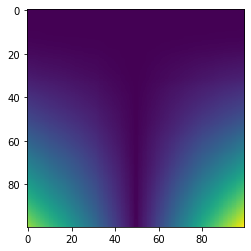

In [31]:
plt.imshow(K_st_tau[299])

In [30]:
K_st_tau[299]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.34963600e-04, 1.34963600e-04, 1.34963600e-04],
       [1.34963600e-04, 1.34963600e-04, 1.34963600e-04, ...,
        2.69927201e-04, 2.69927201e-04, 2.69927201e-04],
       ...,
       [6.69284495e-01, 6.54033608e-01, 6.37568049e-01, ...,
        7.50802509e-01, 7.70102304e-01, 7.93046116e-01],
       [6.82106037e-01, 6.66450259e-01, 6.49714773e-01, ...,
        7.64703760e-01, 7.84408446e-01, 8.07757149e-01],
       [6.99786268e-01, 6.83590636e-01, 6.66585223e-01, ...,
        7.82653919e-01, 8.02898459e-01, 8.27056944e-01]])

In [32]:
K_st_tau_array = []
for i in tqdm(K_st_tau):
    K_st_tau_array.append(K_st_tau[i])
    
K_st_tau_array = np.stack(K_st_tau_array, axis = 0)

  0%|          | 0/500 [00:00<?, ?it/s]

In [33]:
import napari

viewer = napari.Viewer()

viewer.add_image(K_st_tau_array)

Assistant skips harvesting pyclesperanto as it's not installed.


__init__.py (165): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Image layer 'K_st_tau_array' at 0x7f76d98a5df0>

Checking to see if any two of the randomly time-indices-switched K-function arrays are identical (they should not be)

In [62]:
def arrays_equal(a, b):
    if a.shape != b.shape:
        return False
    for ai, bi in zip(a.flat, b.flat):
        if ai != bi:
            return False
    return True

In [85]:
import itertools
for a, b in tqdm(itertools.combinations(K_st_tau, 2), total = 499500):
    array1 = K_st_tau[a]
    array2 = K_st_tau[b]
    if arrays_equal(array1, array2) == True:
        print(a, b, 'are equal')

  0%|          | 0/499500 [00:00<?, ?it/s]

938 937 are equal


In [86]:
N = len(K_st_tau)
P_st_clust = np.zeros(K_st.shape)
P_st_disp = np.zeros(K_st.shape)

for i, h in enumerate(tqdm(h_, total = len(h_))):
    for j, delta in enumerate(delta_):
        M0_plus = len([tau for tau in K_st_tau if K_st_tau[tau][i,j] >= K_st[i,j]])
        P_st_clust[i,j] = (M0_plus + 1)/(N+1)
        M0_minus = len([tau for tau in K_st_tau if K_st_tau[tau][i,j] <= K_st[i,j]])
        P_st_disp[i,j] = (M0_minus + 1)/(N+1)
    

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'P-value contour map of space-time clustering of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 1000 permutations of time values\n')

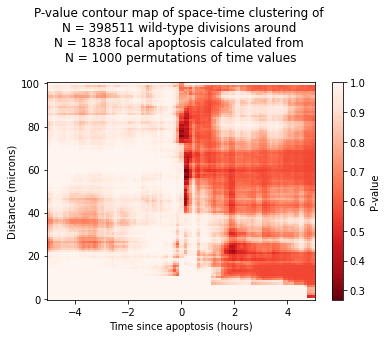

In [87]:
pc = plt.pcolormesh(delta_, h_, (P_st_clust), cmap = 'Reds_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-clustering_100um_10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time dispersion of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 1000 permutations of time values\n')

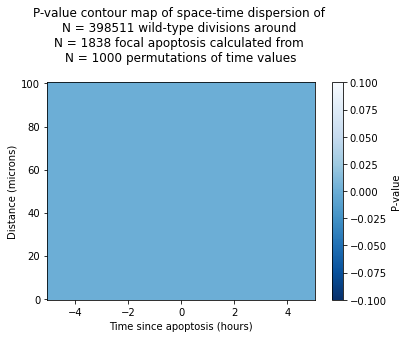

In [93]:
clip_clust = np.zeros((100,100))
clip_clust[P_st_clust <0.1] = P_st_clust[P_st_clust <0.05]
pc = plt.pcolormesh(delta_, h_, clip_clust, cmap = 'Blues_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time dispersion of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-dispersion_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time dispersion of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 1000 permutations of time values\n')

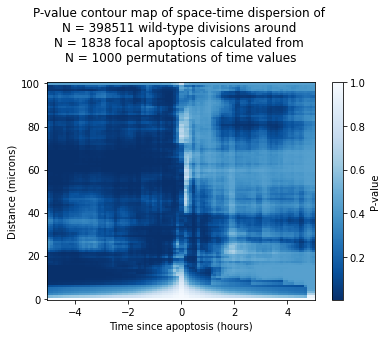

In [90]:
pc = plt.pcolormesh(delta_, h_, P_st_disp, cmap = 'Blues_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time dispersion of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-dispersion_100um_10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time dispersion of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 1000 permutations of time values\n')

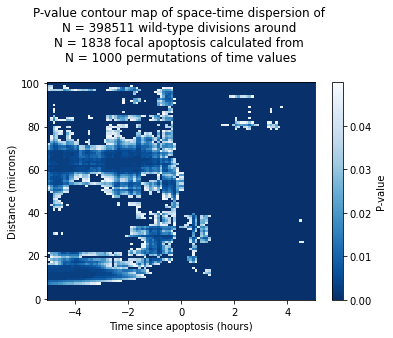

In [91]:
clip_disp = np.zeros((100,100))
clip_disp[P_st_disp <0.05] = P_st_disp[P_st_disp <0.05]
pc = plt.pcolormesh(delta_, h_, clip_disp, cmap = 'Blues_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time dispersion of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-dispersion_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

NameError: name 'clip_clust' is not defined

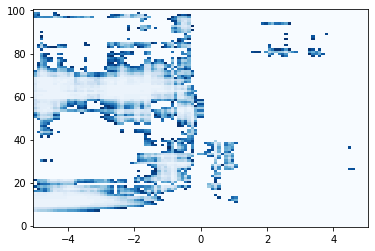

In [92]:
clip_disp = np.zeros((100,100))
clip_disp[P_st_disp <0.05] = P_st_disp[P_st_disp <0.05]
pc = plt.pcolormesh(delta_, h_, clip_disp, cmap = 'Blues',)
plt.pcolormesh(delta_, h_, clip_clust, cmap = 'Reds',alpha = 0.5)
plt.colorbar(label = 'P-value', cmap = 'Grays')
plt.clim(0,0.05)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = {n1} \nwild-type divisions around N = {n2} \nfocal apoptosis calculated from N = {N} \npermutations of time values\n')
#plt.savefig('p-value-division-cluster-dispersion-overlay_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = 398511 \nwild-type divisions around N = 1838 \nfocal apoptosis calculated from N = 500 \npermutations of time values\n')

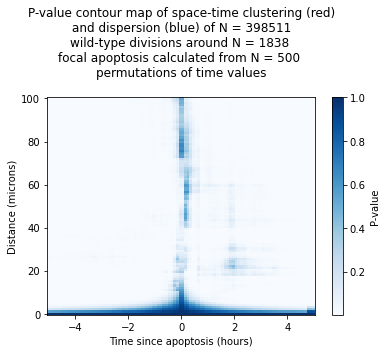

In [43]:

pc = plt.pcolormesh(delta_, h_, P_st_disp, cmap = 'Blues',)
#plt.pcolormesh(delta_, h_, clip_clust, cmap = 'Reds',alpha = 0.5)
plt.colorbar(label = 'P-value', cmap = 'Grays')
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = {n1} \nwild-type divisions around N = {n2} \nfocal apoptosis calculated from N = {N} \npermutations of time values\n')
#plt.savefig('p-value-division-cluster-dispersion-overlay_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

# ARXIV

Text(0.5, 1.0, 'P-value contour map of space-time clustering of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 759 permutations of time values\n')

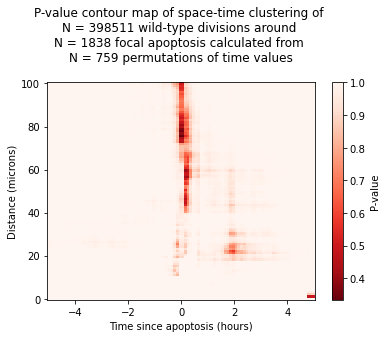

In [139]:
pc = plt.pcolormesh(delta_, h_, (P_st_clust), cmap = 'Reds_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-clustering_100um_10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time clustering of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 500 permutations of time values\n')

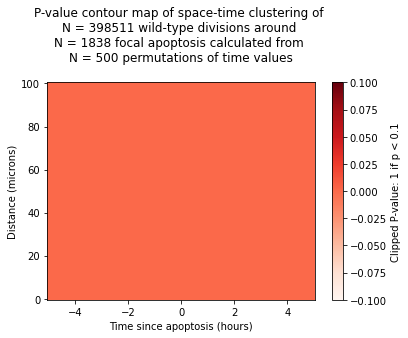

In [36]:
pc = plt.pcolormesh(delta_, h_, P_st_clust < 0.1, cmap = 'Reds', )
plt.colorbar(label = 'Clipped P-value: 1 if p < 0.1',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-clustering_100um_10hrs_clipped_p-0.05.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time clustering of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 500 permutations of time values\n')

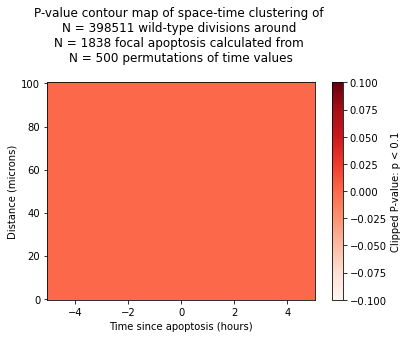

In [37]:
clip_clust = np.zeros((100,100))
clip_clust[P_st_clust <0.1] = P_st_clust[P_st_clust <0.1]
pc = plt.pcolormesh(delta_, h_, clip_clust, cmap = 'Reds', )
plt.colorbar(label = 'Clipped P-value: p < 0.1',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-clustering_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time dispersion of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 759 permutations of time values\n')

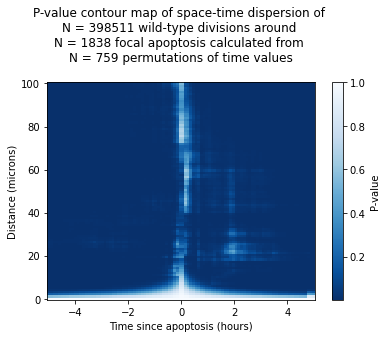

In [142]:
pc = plt.pcolormesh(delta_, h_, P_st_disp, cmap = 'Blues_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time dispersion of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-dispersion_100um_10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time dispersion of \nN = 398511 wild-type divisions around \nN = 1838 focal apoptosis calculated from \nN = 759 permutations of time values\n')

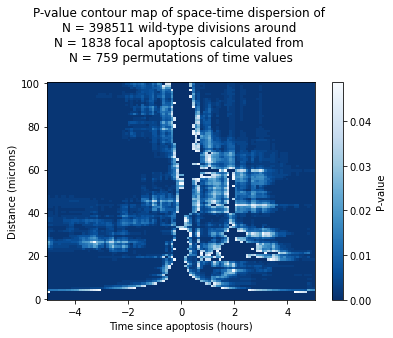

In [143]:
clip_disp = np.zeros((100,100))
clip_disp[P_st_disp <0.05] = P_st_disp[P_st_disp <0.05]
pc = plt.pcolormesh(delta_, h_, clip_disp, cmap = 'Blues_r', )
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time dispersion of \nN = {n1} wild-type divisions around \nN = {n2} focal apoptosis calculated from \nN = {N} permutations of time values\n')
#plt.savefig('p-value-division-dispersion_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = 398511 \nwild-type divisions around N = 1838 \nfocal apoptosis calculated from N = 759 \npermutations of time values\n')

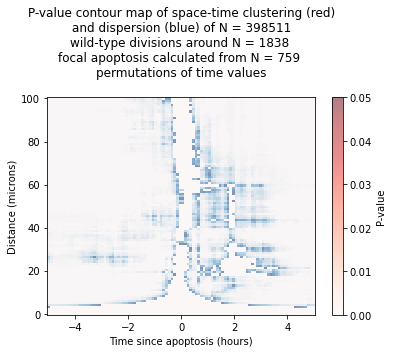

In [144]:
clip_disp = np.zeros((100,100))
clip_disp[P_st_disp <0.05] = P_st_disp[P_st_disp <0.05]
pc = plt.pcolormesh(delta_, h_, clip_disp, cmap = 'Blues',)
plt.pcolormesh(delta_, h_, clip_clust, cmap = 'Reds',alpha = 0.5)
plt.colorbar(label = 'P-value', cmap = 'Grays')
plt.clim(0,0.05)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = {n1} \nwild-type divisions around N = {n2} \nfocal apoptosis calculated from N = {N} \npermutations of time values\n')
#plt.savefig('p-value-division-cluster-dispersion-overlay_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = 398511 \nwild-type divisions around N = 1838 \nfocal apoptosis calculated from N = 1000 \npermutations of time values\n')

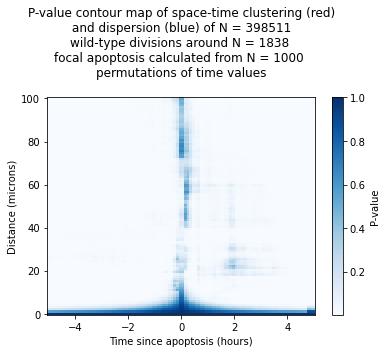

In [135]:

pc = plt.pcolormesh(delta_, h_, P_st_disp, cmap = 'Blues',)
#plt.pcolormesh(delta_, h_, clip_clust, cmap = 'Reds',alpha = 0.5)
plt.colorbar(label = 'P-value', cmap = 'Grays')
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance (microns)')
plt.title(f'P-value contour map of space-time clustering (red)\n and dispersion (blue) of N = {n1} \nwild-type divisions around N = {n2} \nfocal apoptosis calculated from N = {N} \npermutations of time values\n')
#plt.savefig('p-value-division-cluster-dispersion-overlay_100um_10hrs_clipped_p-0.05_fullrange.pdf', bbox_inches = 'tight')